# LSN Esercitazione 06

## Esercizio 06.1

In questo esercizio abbiamo dovuto modificare il codice relativo alla simulazione Monte Carlo di un modello di Ising 1D che ci è stato fornito. In particolare, per simulare il sistema e stimare i valori di diverse grandezze abbiamo implementato l'algoritmo di campionamento di Metropolis e quello di Gibbs.

Nel caso in analisi il campionamento consiste nel selezionare a caso uno spin del nostro reticolo unidimensionale e utilizzare uno dei due algoritmi citati per decidere il suo valore.

Per quanto riguarda l'**algoritmo di Metropolis** la probabilità di transizione $T\left(\nu|\mu\right)$ (simmetrica) consiste nell'identificare lo spin $k$-esimo, dove $\nu$ indica la nuova configurazione (con il nuovo spin $k$-esimo) e $\mu$ la vecchia configurazione (prima di decidere se flippare o meno lo spin). Calcolando

$$A\left(\nu|\mu\right)=\min\left[1,\exp\left[-\beta\left(E_\nu-E_\mu\right)\right]\right]$$

con $E_\nu-E_\mu = 2Js_k^\mu\sum_{\text{i n.n. to k}} s_i^\mu + 2s_k^\mu h$ e confrontandolo con un numero random $r$ generato uniformemente tra 0 e 1, l'algoritmo decide se cambiare il segno dello spin ($r<A\left(\nu|\mu\right)$) o lasciarlo invariato ($r>A\left(\nu|\mu\right)$).

Per l'**algoritmo di Gibbs**, invece, ogni mossa è accettata. La probabilità di avere $s_k^\nu= \pm 1$ nella nuova configurazione, partendo dalla configurazione $\mu$ è

$$p\left(s_k^\nu=\pm1|\{s^\mu_j: j\neq k\}\right)= \frac{1}{1+\exp\left[\mp2\beta\left(J\sum_{\text{i n.n. to k}}s_i^\mu + h\right)\right]}.$$

In seguito per decidere se estrarre $s_k^\nu$ uguale a $+1$ o $-1$, siccome le probabilità appena calcolate sono normalizzate, generiamo un numero casuale tra 0 e 1 e in base al suo valore assegnamo (o meglio, l'algoritmo assegna) $+1$ o $-1$ allo spin.

Dopo aver compiuto una mossa (che consiste nell'assegnare il valore a uno spin estratto casualmente dal reticolo) misuriamo i valori di $H$, $\sum_{i=1,N}s_i$, $\left(\beta\sum_{i=1,N}s_i\right)^2$ e $H^2$ (nella funzione <font face="Fira Code" size=3>Measure()</font>) che ci permetteranno di calcolare le quantità che ci interessano.

Inizialmente consideriamo il campo esterno nullo, $h=0$ e stimiamo le grandezze con le seguenti formule

$$\frac{U(N,T)}{N} = \frac{\langle H \rangle_{h=0}}{N}$$
$$\frac{C(N,T)}{N} = \frac{\beta^2 (\langle H^2 \rangle_{h=0}-\langle H \rangle_{h=0}^2)}{N}$$
$$\chi(N,T) = \beta \langle (\sum_{i=1,N}s_i)^2 \rangle_{h=0}$$

Anzitutto preoccupiamoci dell'equilibrazione del sistema. Per fare questo studiamo l'andamento dei valori istantanei (o meglio, le loro stime) delle grandezze. Noi studieremo solo il caso dell'energia interna, ma la situazione è la medesima per le altre quantità.

Nel grafico sottostante sulla sinistra possiamo osservare che il valore istantaneo dell'energia libera oscilla attorno al valore teorico con la stessa ampiezza per il corso di tutta la simulazione. Questo significa che il sistema è equilibrato fin dall'inizio e non è necessario escludere i tiri iniziali. Quindi anche far ripartire la simulazione non è utile, essendo essa già equilibrata.

Nel grafico sulla destra notiamo inoltre come il valore medio di $U$, con la sua incertezza (ottenuti tramite data blocking) mostrano che si ha convergenza al valore teorico. Nei grafici mostrati abbiamo considerato una temperatura $T=1.0$ e $100$ blocchi (formati da $2*10^4$ passi l'uno); per ogni blocco abbiamo calcolato una stima del valore istantaneo di $U$ (primo grafico) e il suo valore medio (secondo grafico).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # fontsize of the legend

In [3]:
import subprocess

def replace_line(file_name, line_num, text):
    # Apro il file e leggo tutti i dati
    with open(file_name, 'r') as file:
        data = file.readlines()
    # Sostituisco la riga interessata
    data[line_num] = text
    # Riscrivo il file con le righe aggiornate
    with open(file_name, 'w') as file:
        file.writelines(data)

replace_line('input.dat', 0, '0\n')
replace_line('input.dat', 5, '0.00\n') # h = 0.00
replace_line('input.dat', 7, '100\n')
replace_line('input.dat', 8, '20000\n')

subprocess.call("make", shell=True)
subprocess.call("./clean.sh", shell=True)
subprocess.call("./Monte_Carlo_ISING_1D.exe")

subprocess.call("mv output.ene.0 Data/output.ene_eq.0", shell = True)
subprocess.call("rm output.chi.0 output.heat.0 output.mag.0", shell = True)
print("Codice eseguito!")

Codice eseguito!


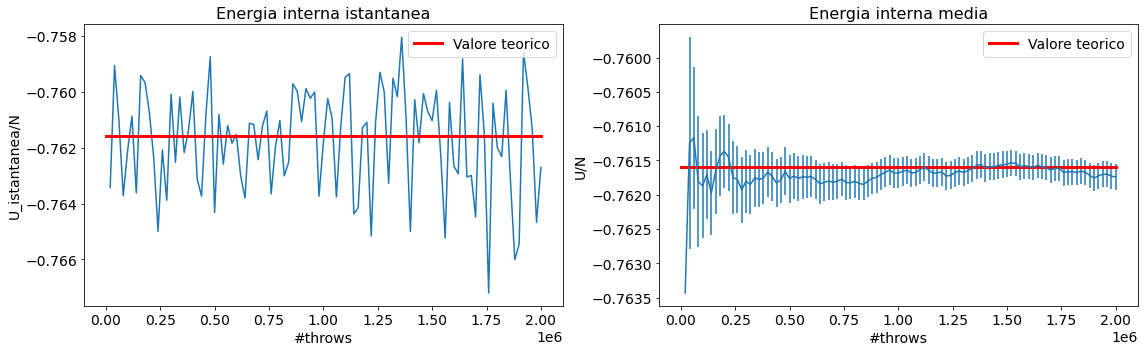

In [4]:
# Carico dati da file
N, u_ist, u_prog, err_prog = ((np.genfromtxt('./Data/output.ene_eq.0', usecols=i, autostrip=True)) for i in range(4))
N *= 2*10**4

# Valore teorico di U/N a temperatura fissata
T = 1.0
beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th
e = -J*( th + ch*thN )/( 1 + thN )
x_mean = np.linspace(0,np.max(N))
y_mean = x_mean*0 + e 

# Disegno il plot
plt.subplots(figsize = (16,5))
plt.subplot(1,2,1)
plt.title('Energia interna istantanea', fontsize=16)
plt.plot(N, u_ist)
plt.plot(x_mean, y_mean, 'r-', linewidth=3, label='Valore teorico')
plt.xlabel('#throws')
plt.ylabel('U_istantanea/N')
plt.legend(loc = 1)

plt.subplot(1,2,2)
plt.title('Energia interna media', fontsize=16)
plt.errorbar(N, u_prog, yerr=err_prog)
plt.plot(x_mean, y_mean, 'r-', linewidth=3, label='Valore teorico')
plt.xlabel('#throws')
plt.ylabel('U/N')
plt.legend(loc = 1)

plt.tight_layout()
plt.show()

Per costruire i plot di energia interna (per spin), capacità termica (per spin), suscettività magnetica e magnetizzazione in funzione della temperatura abbiamo inserito nel codice una nuova opzione. Questa ci permette di scrivere su file il valore medio delle nostre grandezze, la loro incertezza (al variare della temperatura) e la temperatura, la quale non verrà più inserita come output, ma verrà fatta variare all'interno del programma da $0.5$ a $2.0$. Per fare ciò abbiamo inserito nel file <font face="Courier" size=3>input.dat</font> una variabile, chiamata *ReadTemp*, a cui assegnamo il valore 0 se vogliamo leggere da file la temperatura a cui fare l'esperimento e il valore 1 se vogliamo invece far variare la temperatura da $0.5$ a $2.0$ all'interno del programma. Inoltre nel file <font face="Courier" size=3>input.dat</font> abbiamo aggiunto la variabile *temp_step* con la quale possiamo decidere quanto debbano essere distanti due temperature successive nella nostra simulazione.

Nella simulazione qui riportata abbiamo utilizzato $20$ blocchi con $10^5$ lanci ciascuno. I grafici successivi mostrano che i valori di energia interna per spin, capacità termica per spin e suscettività magnetica seguono con precisione i valori teorici, mostrando un buon accordo tra teoria e simulazione. In ogni plot è presente uno zoom su una parte del grafico che ci permette di essere più accurati e osservare che i valori medi delle grandezze calcolate seguono in modo soddisfacente l'andamento teorico delle suddette; notiamo però che le barre d'errore non sempre vanno a intersecare la curva del valore atteso.

In [5]:
replace_line('input.dat', 0, '1\n')
replace_line('input.dat', 5, '0.00\n') # h = 0.00
replace_line('input.dat', 6, '1\n') # Metropolis
replace_line('input.dat', 7, '20\n')
replace_line('input.dat', 8, '100000\n')

subprocess.call("./clean.sh", shell=True)
subprocess.call("./Monte_Carlo_ISING_1D.exe")

subprocess.call("mv -t Data/h=0 output.ene_temp_Metropolis.0 output.heat_temp_Metropolis.0 output.chi_temp_Metropolis.0", shell = True)
print("Codice eseguito!")

Codice eseguito!


In [6]:
replace_line('input.dat', 6, '0\n') # Gibbs
subprocess.call("./clean.sh", shell=True)
subprocess.call("./Monte_Carlo_ISING_1D.exe")

subprocess.call("mv -t Data/h=0 output.ene_temp_Gibbs.0 output.heat_temp_Gibbs.0 output.chi_temp_Gibbs.0", shell = True)

print("Codice eseguito!")

Codice eseguito!


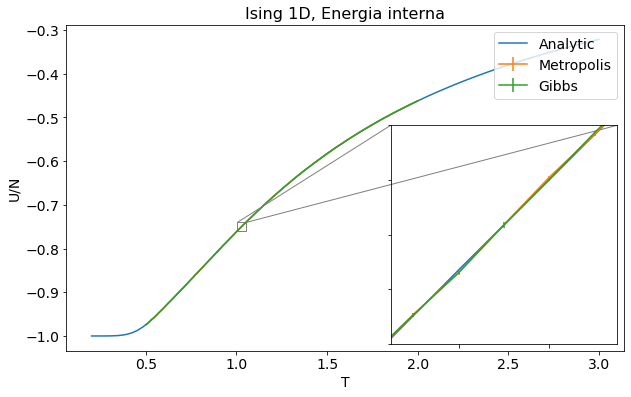

In [7]:
# Soluzione analitica
points=100
T = np.linspace(0.2,3.0,num=points)
beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th
e = -J*( th + ch*thN )/( 1 + thN )

# Preparo la figura
fig, ax = plt.subplots(figsize=(10,6))
plt.title('Ising 1D, Energia interna', fontsize=16)
plt.xlabel('T')
plt.ylabel('U/N')

# Zoom
x1, x2, y1, y2 = 1.005, 1.055, -0.76,-0.74
axins = zoomed_inset_axes(ax, zoom=25, loc=4)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")

# Grafico soluzione analitica
ax.plot(T, e, label='Analytic')
axins.plot(T, e)


temp, u_prog, errU_prog = ((np.genfromtxt('./Data/h=0/output.ene_temp_Metropolis.0', usecols=i, autostrip=True)) for i in range(3))

# Grafico algoritmo di Metropolis
ax.errorbar(temp, u_prog, yerr=errU_prog, label='Metropolis')
axins.errorbar(temp, u_prog, yerr=errU_prog)


temp, u_prog, errU_prog = ((np.genfromtxt('./Data/h=0/output.ene_temp_Gibbs.0', usecols=i, autostrip=True)) for i in range(3))

# Grafico algoritmo di Gibbs
ax.errorbar(temp, u_prog, yerr=errU_prog, label='Gibbs')
axins.errorbar(temp, u_prog, yerr=errU_prog)

ax.legend(loc=1)

plt.draw()
plt.show()

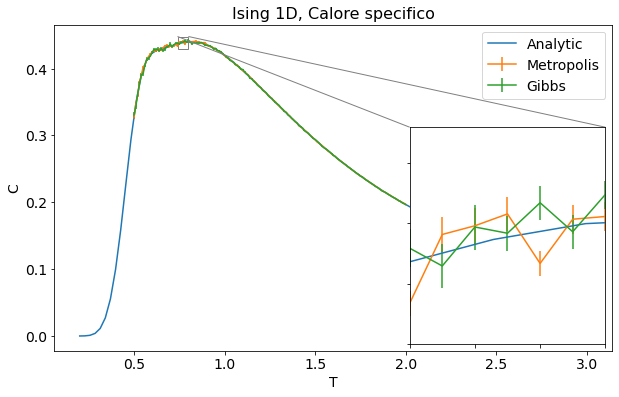

In [8]:
# Soluzione analitica
heat=((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)

# Preparo la figura
fig, ax = plt.subplots(figsize=(10,6))
plt.title('Ising 1D, Calore specifico', fontsize=16)
plt.xlabel('T')
plt.ylabel('C')

# Zoom
x1, x2, y1, y2 = 0.74, 0.80, 0.43, 0.448
axins = zoomed_inset_axes(ax, zoom=18, loc=4)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")

# Grafico soluzione analitica
ax.plot(T, heat, label='Analytic')
axins.plot(T, heat)

temp, c_prog, errC_prog = ((np.genfromtxt('./Data/h=0/output.heat_temp_Metropolis.0', usecols=i, autostrip=True)) for i in range(3))

# Grafico algoritmo di Metropolis
ax.errorbar(temp, c_prog, yerr=errC_prog, label='Metropolis')
axins.errorbar(temp, c_prog, yerr=errC_prog)


temp, c_prog, errC_prog = ((np.genfromtxt('./Data/h=0/output.heat_temp_Gibbs.0', usecols=i, autostrip=True)) for i in range(3))

# Grafico algoritmo di Gibbs
ax.errorbar(temp, c_prog, yerr=errC_prog, label='Gibbs')
axins.errorbar(temp, c_prog, yerr=errC_prog)

ax.legend(loc=1)

plt.show()

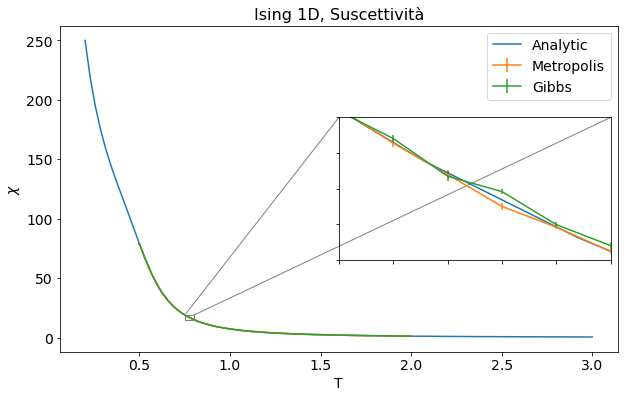

In [9]:
# Soluzione analitica
X = beta*np.exp(2*beta*J)*(1-thN)/(1+thN)

# Preparo la figura
fig, ax = plt.subplots(figsize=(10,6))
plt.title('Ising 1D, Suscettività', fontsize=16)
plt.xlabel('T')
plt.ylabel('$\chi$')

# Zoom
x1, x2, y1, y2 = 0.75, 0.80, 15, 19
axins = zoomed_inset_axes(ax, zoom=30, loc=7)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")

# Grafico soluzione analitica
ax.plot(T, X, label='Analytic')
axins.plot(T, X)


temp, m_prog, errM_prog = ((np.genfromtxt('./Data/h=0/output.chi_temp_Metropolis.0', usecols=i, autostrip=True)) for i in range(3))

# Grafico algoritmo di Metropolis
ax.errorbar(temp, m_prog, yerr=errM_prog, label='Metropolis')
axins.errorbar(temp, m_prog, yerr=errM_prog)


temp, m_prog, errM_prog = ((np.genfromtxt('./Data/h=0/output.chi_temp_Gibbs.0', usecols=i, autostrip=True)) for i in range(3))

# Grafico algoritmo di Gibbs
ax.errorbar(temp, m_prog, yerr=errM_prog, label='Gibbs')
axins.errorbar(temp, m_prog, yerr=errM_prog)

ax.legend(loc=1)

plt.show()

In seguito poniamo il campo esterno $h=0.02$ e calcoliamo la magnetizzazione per spin, che nel caso precedente sarebbe stata nulla, dato che $\langle \sum_{i=1,N}s_i \rangle_{h=0} =0$.

Calcolando
$$M(N,T,h=0.02)= \left\langle \sum_{i=1,N}s_i \right\rangle_{h=0.02}$$
tramite la simulazione Monte Carlo (sempre utilizzando campionamento di Metropolis e campionamento di Gibbs), otteniamo quindi un ottimo accordo col valore teorico, come mostrato nel plot seguente.

In [10]:
replace_line('input.dat', 5, '0.02\n') # h = 0.02
replace_line('input.dat', 6, '1\n') # Metropolis

subprocess.call("./clean.sh", shell=True)
subprocess.call("./Monte_Carlo_ISING_1D.exe")

subprocess.call("mv -t Data/h=0.02 output.mag_temp_Metropolis.0", shell = True)
subprocess.call("rm output.ene_temp_Metropolis.0 output.heat_temp_Metropolis.0 output.chi_temp_Metropolis.0", shell = True)

print("Codice eseguito!")

Codice eseguito!


In [11]:
replace_line('input.dat', 6, '0\n') # Gibbs

subprocess.call("./clean.sh", shell=True)
subprocess.call("./Monte_Carlo_ISING_1D.exe")

subprocess.call("mv -t Data/h=0.02 output.mag_temp_Gibbs.0", shell = True)
subprocess.call("rm output.ene_temp_Gibbs.0 output.heat_temp_Gibbs.0 output.chi_temp_Gibbs.0", shell = True)

print("Codice eseguito!")

Codice eseguito!


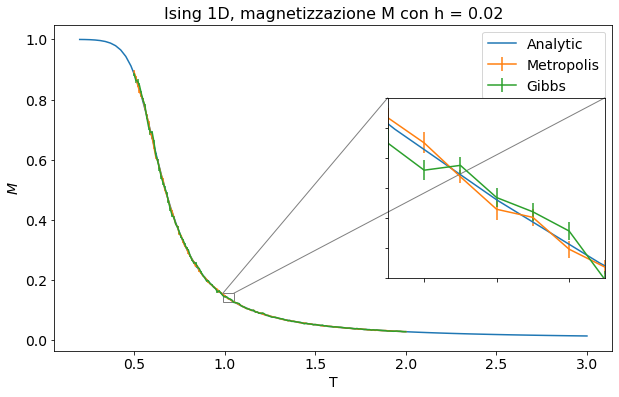

In [12]:
# Soluzione analitica
h=0.02 # Campo esterno
b = 1/T

l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
Z = l1**Ns + l2**Ns

M = (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
        + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)


# Preparo la figura
fig, ax = plt.subplots(figsize=(10,6))
plt.title('Ising 1D, magnetizzazione M con h = 0.02', fontsize=16)
plt.xlabel('T')
plt.ylabel('$M$')

# Zoom
x1, x2, y1, y2 = 0.99, 1.05, 0.125, 0.155
axins = zoomed_inset_axes(ax, zoom=20, loc=7)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=1, fc="none", ec="0.5")

# Grafico soluzione analitica
ax.plot(T, M, label='Analytic')
axins.plot(T, M)


temp, x_prog, errX_prog = ((np.genfromtxt('./Data/h=0.02/output.mag_temp_Metropolis.0', usecols=i, autostrip=True)) for i in range(3))

# Grafico algoritmo di Metropolis
ax.errorbar(temp, x_prog, yerr=errX_prog, label='Metropolis')
axins.errorbar(temp, x_prog, yerr=errX_prog)


temp, x_prog, errX_prog = ((np.genfromtxt('./Data/h=0.02/output.mag_temp_Gibbs.0', usecols=i, autostrip=True)) for i in range(3))

# Grafico algoritmo di Gibbs
ax.errorbar(temp, x_prog, yerr=errX_prog, label='Gibbs')
axins.errorbar(temp, x_prog, yerr=errX_prog)

ax.legend(loc=1)

plt.show()